In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = ct.NOT_DELIVERYING_PENALTY 

## System initializer

In [3]:
def initialize_test_system(noise = False, seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = noise
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
print("States space dimension: ",toy_system.states_dim)
print("Actions space dimension: ",toy_system.actions_dim)
a_s_dim = toy_system.states_dim * toy_system.actions_dim
print("States-Actions space dimension: ",a_s_dim)

States space dimension:  36864
Actions space dimension:  36
States-Actions space dimension:  1327104


In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print("Tank max loads: ",system.tank_max_loads())
print("Tank dayly rates: ",system.tank_rates())
print("Truck max loads: ",system.truck_max_loads())
print("Graph: \n",system.graph)
print("Weights: \n", system.weights)

Tank max loads:  [100.0, 200.0, 100.0, 800.0, 200.0]
Tank dayly rates:  [16.5, 4.0, 10.500000000000002, 84.00000000000001, 34.0]
Truck max loads:  [70.0, 130.0]
Graph: 
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
Weights: 
 [[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

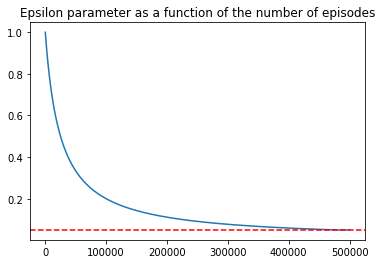

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 5*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3 #3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 228
add_noise = True

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system(noise = add_noise, seed = seed)
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

if train_epsilon == False and retrain == False:
     pass
else: # Create directories for the simulations' outputs

    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

    if not os.path.exists(simulation_directory):
        os.makedirs(simulation_directory)
        os.makedirs(simulation_directory + '/Q-dictionaries')
        os.makedirs(simulation_directory + '/discrewards')
        os.makedirs(simulation_directory + '/vis')

    else:
        raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")


    ut.save_obj(toy_system, simulation_directory+"/system-sim"+"{}".format(simulation_id)) 

    # Output headers to file
    with open(rewards_file,'w') as f:
         np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


Exception: The simulation id you tried to use has been already used before. Try to change it to a new one.

In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print("Training finished. Total episodes: {}. Elapsed time: {} minutes.".format(n_episodes,round(end_time/60., round_time)))        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
# if train_epsilon == False and retrain == False:
#     pass
# elif train_epsilon == True and retrain == False:
#     episodic_train_Q_epsilon()
# elif train_epsilon == False and retrain == True:
#     Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode_retrain))
#     episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
# else:
#     raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    

Episode: 100. Elapsed time  0.1  minuts. epsilon 0.9961 Discounted reward:  -23.906546580925866
Episode: 200. Elapsed time  0.22  minuts. epsilon 0.9921 Discounted reward:  -24.491823884061148
Episode: 300. Elapsed time  0.39  minuts. epsilon 0.9882 Discounted reward:  -23.30333667484793
Episode: 400. Elapsed time  0.57  minuts. epsilon 0.9843 Discounted reward:  -23.390568955163115
Episode: 500. Elapsed time  0.74  minuts. epsilon 0.9804 Discounted reward:  -25.651465749165865
Episode: 600. Elapsed time  0.95  minuts. epsilon 0.9766 Discounted reward:  -26.39026975933794
Episode: 700. Elapsed time  1.17  minuts. epsilon 0.9728 Discounted reward:  -26.851392102391397
Episode: 800. Elapsed time  1.39  minuts. epsilon 0.969 Discounted reward:  -20.76190009778932
Episode: 900. Elapsed time  1.63  minuts. epsilon 0.9653 Discounted reward:  -21.72184388718062
Episode: 1000. Elapsed time  1.87  minuts. epsilon 0.9616 Discounted reward:  -26.397470271782467
Episode: 1100. Elapsed time  2.13  

Episode: 8500. Elapsed time  38.42  minuts. epsilon 0.7463 Discounted reward:  -22.94248151740428
Episode: 8600. Elapsed time  39.06  minuts. epsilon 0.7441 Discounted reward:  -20.900350104820248
Episode: 8700. Elapsed time  39.73  minuts. epsilon 0.7419 Discounted reward:  -20.440304203415945
Episode: 8800. Elapsed time  40.35  minuts. epsilon 0.7397 Discounted reward:  -21.371115331242994
Episode: 8900. Elapsed time  41.01  minuts. epsilon 0.7375 Discounted reward:  -20.354039984809663
Episode: 9000. Elapsed time  41.65  minuts. epsilon 0.7353 Discounted reward:  -25.098213112133838
Episode: 9100. Elapsed time  42.28  minuts. epsilon 0.7332 Discounted reward:  -22.924183027931086
Episode: 9200. Elapsed time  42.91  minuts. epsilon 0.731 Discounted reward:  -26.443296018186818
Episode: 9300. Elapsed time  43.56  minuts. epsilon 0.7289 Discounted reward:  -19.98449383871857
Episode: 9400. Elapsed time  44.23  minuts. epsilon 0.7268 Discounted reward:  -15.80284534815455
Episode: 9500.

Episode: 16800. Elapsed time  96.75  minuts. epsilon 0.5981 Discounted reward:  -15.363792241639963
Episode: 16900. Elapsed time  97.5  minuts. epsilon 0.5967 Discounted reward:  -17.438505478548446
Episode: 17000. Elapsed time  98.23  minuts. epsilon 0.5953 Discounted reward:  -21.135715101234904
Episode: 17100. Elapsed time  98.97  minuts. epsilon 0.5938 Discounted reward:  -17.874258089317568
Episode: 17200. Elapsed time  99.72  minuts. epsilon 0.5924 Discounted reward:  -23.273145665315806
Episode: 17300. Elapsed time  100.48  minuts. epsilon 0.591 Discounted reward:  -18.592531537500726
Episode: 17400. Elapsed time  101.24  minuts. epsilon 0.5896 Discounted reward:  -16.919257369844416
Episode: 17500. Elapsed time  101.99  minuts. epsilon 0.5882 Discounted reward:  -22.500942595247217
Episode: 17600. Elapsed time  102.8  minuts. epsilon 0.5869 Discounted reward:  -14.178693720310335
Episode: 17700. Elapsed time  103.88  minuts. epsilon 0.5855 Discounted reward:  -15.52887972143222

Episode: 25000. Elapsed time  174.28  minuts. epsilon 0.5 Discounted reward:  -17.312569060194473
Episode: 25100. Elapsed time  175.17  minuts. epsilon 0.499 Discounted reward:  -23.821631389993012
Episode: 25200. Elapsed time  176.37  minuts. epsilon 0.498 Discounted reward:  -14.251204900163291
Episode: 25300. Elapsed time  177.28  minuts. epsilon 0.497 Discounted reward:  -15.190938075906875
Episode: 25400. Elapsed time  178.19  minuts. epsilon 0.496 Discounted reward:  -13.436698539937083
Episode: 25500. Elapsed time  179.14  minuts. epsilon 0.4951 Discounted reward:  -20.88806211734788
Episode: 25600. Elapsed time  180.07  minuts. epsilon 0.4941 Discounted reward:  -22.154868588262662
Episode: 25700. Elapsed time  181.03  minuts. epsilon 0.4931 Discounted reward:  -13.678821401142846
Episode: 25800. Elapsed time  181.98  minuts. epsilon 0.4921 Discounted reward:  -16.957871168965855
Episode: 25900. Elapsed time  182.89  minuts. epsilon 0.4912 Discounted reward:  -17.90439020866946

Episode: 33200. Elapsed time  277.46  minuts. epsilon 0.4296 Discounted reward:  -16.32158435620921
Episode: 33300. Elapsed time  278.44  minuts. epsilon 0.4288 Discounted reward:  -16.7571200296072
Episode: 33400. Elapsed time  279.41  minuts. epsilon 0.4281 Discounted reward:  -14.990710818848974
Episode: 33500. Elapsed time  280.4  minuts. epsilon 0.4274 Discounted reward:  -19.101096241803454
Episode: 33600. Elapsed time  281.37  minuts. epsilon 0.4266 Discounted reward:  -16.749367717613968
Episode: 33700. Elapsed time  282.37  minuts. epsilon 0.4259 Discounted reward:  -15.646831144977497
Episode: 33800. Elapsed time  283.33  minuts. epsilon 0.4252 Discounted reward:  -15.901193871055955
Episode: 33900. Elapsed time  284.3  minuts. epsilon 0.4245 Discounted reward:  -21.416804318912053
Episode: 34000. Elapsed time  285.28  minuts. epsilon 0.4237 Discounted reward:  -13.738326153285962
Episode: 34100. Elapsed time  286.24  minuts. epsilon 0.423 Discounted reward:  -16.724010207418

Episode: 41400. Elapsed time  362.35  minuts. epsilon 0.3765 Discounted reward:  -14.745566295809514
Episode: 41500. Elapsed time  363.52  minuts. epsilon 0.3759 Discounted reward:  -12.850828790669736
Episode: 41600. Elapsed time  364.65  minuts. epsilon 0.3754 Discounted reward:  -13.46839334032653
Episode: 41700. Elapsed time  365.76  minuts. epsilon 0.3748 Discounted reward:  -15.016437857215372
Episode: 41800. Elapsed time  366.87  minuts. epsilon 0.3743 Discounted reward:  -10.762376224466927
Episode: 41900. Elapsed time  367.97  minuts. epsilon 0.3737 Discounted reward:  -14.937450595190843
Episode: 42000. Elapsed time  369.46  minuts. epsilon 0.3731 Discounted reward:  -12.687298740185769
Episode: 42100. Elapsed time  370.65  minuts. epsilon 0.3726 Discounted reward:  -13.690413102782601
Episode: 42200. Elapsed time  371.74  minuts. epsilon 0.372 Discounted reward:  -14.871676056294124
Episode: 42300. Elapsed time  372.86  minuts. epsilon 0.3715 Discounted reward:  -14.70706809

Episode: 49600. Elapsed time  477.16  minuts. epsilon 0.3351 Discounted reward:  -13.378058630775307
Episode: 49700. Elapsed time  478.31  minuts. epsilon 0.3347 Discounted reward:  -17.732136582634805
Episode: 49800. Elapsed time  479.45  minuts. epsilon 0.3342 Discounted reward:  -12.444164484289363
Episode: 49900. Elapsed time  480.57  minuts. epsilon 0.3338 Discounted reward:  -13.230549918082804
Episode: 50000. Elapsed time  481.73  minuts. epsilon 0.3333 Discounted reward:  -16.003627313898342
Episode: 50100. Elapsed time  482.87  minuts. epsilon 0.3329 Discounted reward:  -15.433380721144852
Episode: 50200. Elapsed time  484.04  minuts. epsilon 0.3325 Discounted reward:  -13.117569321966204
Episode: 50300. Elapsed time  485.22  minuts. epsilon 0.332 Discounted reward:  -16.343082808465063
Episode: 50400. Elapsed time  486.38  minuts. epsilon 0.3316 Discounted reward:  -16.773329775502862
Episode: 50500. Elapsed time  487.51  minuts. epsilon 0.3311 Discounted reward:  -16.0984172

Episode: 57800. Elapsed time  582.76  minuts. epsilon 0.3019 Discounted reward:  -10.822846289407792
Episode: 57900. Elapsed time  583.81  minuts. epsilon 0.3016 Discounted reward:  -12.085187518256612
Episode: 58000. Elapsed time  584.9  minuts. epsilon 0.3012 Discounted reward:  -14.657028654875958
Episode: 58100. Elapsed time  586.03  minuts. epsilon 0.3008 Discounted reward:  -12.274409408308347
Episode: 58200. Elapsed time  587.09  minuts. epsilon 0.3005 Discounted reward:  -19.551486299321407
Episode: 58300. Elapsed time  588.17  minuts. epsilon 0.3001 Discounted reward:  -11.48349481840083
Episode: 58400. Elapsed time  589.23  minuts. epsilon 0.2998 Discounted reward:  -10.904764090130762
Episode: 58500. Elapsed time  590.31  minuts. epsilon 0.2994 Discounted reward:  -21.257982564393338
Episode: 58600. Elapsed time  591.4  minuts. epsilon 0.299 Discounted reward:  -13.06441557987991
Episode: 58700. Elapsed time  592.5  minuts. epsilon 0.2987 Discounted reward:  -14.660579663731

Episode: 66000. Elapsed time  671.4  minuts. epsilon 0.2747 Discounted reward:  -13.394091509312965
Episode: 66100. Elapsed time  672.47  minuts. epsilon 0.2744 Discounted reward:  -15.919722826284087
Episode: 66200. Elapsed time  673.59  minuts. epsilon 0.2741 Discounted reward:  -13.127770493442354
Episode: 66300. Elapsed time  674.65  minuts. epsilon 0.2738 Discounted reward:  -10.841414236113039
Episode: 66400. Elapsed time  675.77  minuts. epsilon 0.2735 Discounted reward:  -13.022624493903644
Episode: 66500. Elapsed time  676.89  minuts. epsilon 0.2732 Discounted reward:  -10.591436441703317
Episode: 66600. Elapsed time  677.97  minuts. epsilon 0.2729 Discounted reward:  -11.66615013616906
Episode: 66700. Elapsed time  679.03  minuts. epsilon 0.2726 Discounted reward:  -10.409806963170261
Episode: 66800. Elapsed time  680.11  minuts. epsilon 0.2723 Discounted reward:  -13.341101488517712
Episode: 66900. Elapsed time  681.2  minuts. epsilon 0.272 Discounted reward:  -15.6150242876

Episode: 74200. Elapsed time  761.4  minuts. epsilon 0.252 Discounted reward:  -13.543215925880908
Episode: 74300. Elapsed time  762.47  minuts. epsilon 0.2518 Discounted reward:  -16.04356592397337
Episode: 74400. Elapsed time  763.58  minuts. epsilon 0.2515 Discounted reward:  -11.074875761182314
Episode: 74500. Elapsed time  764.68  minuts. epsilon 0.2513 Discounted reward:  -12.42058103846402
Episode: 74600. Elapsed time  765.77  minuts. epsilon 0.251 Discounted reward:  -12.328108985644084
Episode: 74700. Elapsed time  766.85  minuts. epsilon 0.2508 Discounted reward:  -13.8842711560252
Episode: 74800. Elapsed time  767.95  minuts. epsilon 0.2505 Discounted reward:  -10.286827656583087
Episode: 74900. Elapsed time  769.05  minuts. epsilon 0.2503 Discounted reward:  -12.778913433038927
Episode: 75000. Elapsed time  770.09  minuts. epsilon 0.25 Discounted reward:  -12.076033701990285
Episode: 75100. Elapsed time  771.21  minuts. epsilon 0.2498 Discounted reward:  -11.022552909675472

Episode: 82400. Elapsed time  853.18  minuts. epsilon 0.2328 Discounted reward:  -13.711971286595025
Episode: 82500. Elapsed time  854.33  minuts. epsilon 0.2326 Discounted reward:  -12.349420952718305
Episode: 82600. Elapsed time  855.44  minuts. epsilon 0.2323 Discounted reward:  -12.011055982435186
Episode: 82700. Elapsed time  856.56  minuts. epsilon 0.2321 Discounted reward:  -13.763963327573402
Episode: 82800. Elapsed time  857.68  minuts. epsilon 0.2319 Discounted reward:  -12.993975826772472
Episode: 82900. Elapsed time  858.82  minuts. epsilon 0.2317 Discounted reward:  -10.449480689799948
Episode: 83000. Elapsed time  859.97  minuts. epsilon 0.2315 Discounted reward:  -10.898166809582763
Episode: 83100. Elapsed time  861.1  minuts. epsilon 0.2313 Discounted reward:  -16.316644184632164
Episode: 83200. Elapsed time  862.19  minuts. epsilon 0.2311 Discounted reward:  -18.330975846098568
Episode: 83300. Elapsed time  863.35  minuts. epsilon 0.2308 Discounted reward:  -17.4190640

Episode: 90600. Elapsed time  945.86  minuts. epsilon 0.2163 Discounted reward:  -17.07078292224121
Episode: 90700. Elapsed time  946.96  minuts. epsilon 0.2161 Discounted reward:  -12.402758434214297
Episode: 90800. Elapsed time  948.13  minuts. epsilon 0.2159 Discounted reward:  -13.616555630113666
Episode: 90900. Elapsed time  949.27  minuts. epsilon 0.2157 Discounted reward:  -11.238114959465765
Episode: 91000. Elapsed time  950.43  minuts. epsilon 0.2155 Discounted reward:  -10.928539449857992
Episode: 91100. Elapsed time  951.56  minuts. epsilon 0.2153 Discounted reward:  -14.769394524604982
Episode: 91200. Elapsed time  952.66  minuts. epsilon 0.2151 Discounted reward:  -11.27731915904558
Episode: 91300. Elapsed time  953.81  minuts. epsilon 0.215 Discounted reward:  -17.876688335278274
Episode: 91400. Elapsed time  954.96  minuts. epsilon 0.2148 Discounted reward:  -11.015515675710663
Episode: 91500. Elapsed time  956.1  minuts. epsilon 0.2146 Discounted reward:  -12.2827232114

Episode: 98800. Elapsed time  1039.04  minuts. epsilon 0.2019 Discounted reward:  -14.633034996158088
Episode: 98900. Elapsed time  1040.05  minuts. epsilon 0.2018 Discounted reward:  -11.894445448855876
Episode: 99000. Elapsed time  1041.08  minuts. epsilon 0.2016 Discounted reward:  -14.5438124586378
Episode: 99100. Elapsed time  1042.06  minuts. epsilon 0.2015 Discounted reward:  -13.156340474915265
Episode: 99200. Elapsed time  1043.09  minuts. epsilon 0.2013 Discounted reward:  -11.75086781389308
Episode: 99300. Elapsed time  1044.11  minuts. epsilon 0.2011 Discounted reward:  -14.574478898236336
Episode: 99400. Elapsed time  1045.12  minuts. epsilon 0.201 Discounted reward:  -9.084983428007536
Episode: 99500. Elapsed time  1046.11  minuts. epsilon 0.2008 Discounted reward:  -14.363301796893689
Episode: 99600. Elapsed time  1047.09  minuts. epsilon 0.2006 Discounted reward:  -16.163235946425303
Episode: 99700. Elapsed time  1048.1  minuts. epsilon 0.2005 Discounted reward:  -11.95

Episode: 106900. Elapsed time  1119.58  minuts. epsilon 0.1895 Discounted reward:  -14.211915819429606
Episode: 107000. Elapsed time  1120.61  minuts. epsilon 0.1894 Discounted reward:  -10.470256659644479
Episode: 107100. Elapsed time  1121.6  minuts. epsilon 0.1893 Discounted reward:  -15.956029316259691
Episode: 107200. Elapsed time  1122.58  minuts. epsilon 0.1891 Discounted reward:  -10.162162720809935
Episode: 107300. Elapsed time  1123.56  minuts. epsilon 0.189 Discounted reward:  -12.923135072881685
Episode: 107400. Elapsed time  1124.55  minuts. epsilon 0.1888 Discounted reward:  -11.419798482515617
Episode: 107500. Elapsed time  1125.54  minuts. epsilon 0.1887 Discounted reward:  -8.513965739835928
Episode: 107600. Elapsed time  1126.52  minuts. epsilon 0.1885 Discounted reward:  -11.810345955124136
Episode: 107700. Elapsed time  1127.51  minuts. epsilon 0.1884 Discounted reward:  -13.32679332616592
Episode: 107800. Elapsed time  1128.56  minuts. epsilon 0.1883 Discounted rew

Episode: 114900. Elapsed time  1196.08  minuts. epsilon 0.1787 Discounted reward:  -12.97245738766475
Episode: 115000. Elapsed time  1196.99  minuts. epsilon 0.1786 Discounted reward:  -9.49467693463394
Episode: 115100. Elapsed time  1197.89  minuts. epsilon 0.1784 Discounted reward:  -9.824271057197688
Episode: 115200. Elapsed time  1198.81  minuts. epsilon 0.1783 Discounted reward:  -12.606149372976295
Episode: 115300. Elapsed time  1199.72  minuts. epsilon 0.1782 Discounted reward:  -11.265858389920652
Episode: 115400. Elapsed time  1200.63  minuts. epsilon 0.1781 Discounted reward:  -13.578504526737172
Episode: 115500. Elapsed time  1201.53  minuts. epsilon 0.1779 Discounted reward:  -11.961080625974953
Episode: 115600. Elapsed time  1202.43  minuts. epsilon 0.1778 Discounted reward:  -9.837545405506102
Episode: 115700. Elapsed time  1203.34  minuts. epsilon 0.1777 Discounted reward:  -10.868306409814217
Episode: 115800. Elapsed time  1204.25  minuts. epsilon 0.1776 Discounted rewa

Episode: 122900. Elapsed time  1267.26  minuts. epsilon 0.169 Discounted reward:  -9.418436525849641
Episode: 123000. Elapsed time  1268.14  minuts. epsilon 0.1689 Discounted reward:  -14.975945506981288
Episode: 123100. Elapsed time  1269.02  minuts. epsilon 0.1688 Discounted reward:  -14.085861248696979
Episode: 123200. Elapsed time  1269.89  minuts. epsilon 0.1687 Discounted reward:  -14.75194532312408
Episode: 123300. Elapsed time  1270.77  minuts. epsilon 0.1686 Discounted reward:  -10.510441055208275
Episode: 123400. Elapsed time  1271.65  minuts. epsilon 0.1685 Discounted reward:  -11.407662748195506
Episode: 123500. Elapsed time  1272.52  minuts. epsilon 0.1684 Discounted reward:  -12.226436713586338
Episode: 123600. Elapsed time  1273.39  minuts. epsilon 0.1682 Discounted reward:  -11.329105718348572
Episode: 123700. Elapsed time  1274.27  minuts. epsilon 0.1681 Discounted reward:  -10.961760086584642
Episode: 123800. Elapsed time  1275.13  minuts. epsilon 0.168 Discounted rew

Episode: 138900. Elapsed time  1394.96  minuts. epsilon 0.1525 Discounted reward:  -12.504405611895244
Episode: 139000. Elapsed time  1395.8  minuts. epsilon 0.1524 Discounted reward:  -12.494532491004723
Episode: 139100. Elapsed time  1396.65  minuts. epsilon 0.1523 Discounted reward:  -11.900827311669302
Episode: 139200. Elapsed time  1397.49  minuts. epsilon 0.1523 Discounted reward:  -11.635851678365356
Episode: 139300. Elapsed time  1398.34  minuts. epsilon 0.1522 Discounted reward:  -13.323692896545513
Episode: 139400. Elapsed time  1399.12  minuts. epsilon 0.1521 Discounted reward:  -13.120135863605597
Episode: 139500. Elapsed time  1399.93  minuts. epsilon 0.152 Discounted reward:  -12.161291594198287
Episode: 139600. Elapsed time  1400.77  minuts. epsilon 0.1519 Discounted reward:  -10.348537838557368
Episode: 139700. Elapsed time  1401.61  minuts. epsilon 0.1518 Discounted reward:  -14.044061813118523
Episode: 139800. Elapsed time  1402.45  minuts. epsilon 0.1517 Discounted r

Episode: 146900. Elapsed time  1462.52  minuts. epsilon 0.1454 Discounted reward:  -10.057148266052682
Episode: 147000. Elapsed time  1463.39  minuts. epsilon 0.1453 Discounted reward:  -11.676668181043633
Episode: 147100. Elapsed time  1464.25  minuts. epsilon 0.1453 Discounted reward:  -9.54117245394143
Episode: 147200. Elapsed time  1465.13  minuts. epsilon 0.1452 Discounted reward:  -10.820638654927588
Episode: 147300. Elapsed time  1466.01  minuts. epsilon 0.1451 Discounted reward:  -10.24806871330809
Episode: 147400. Elapsed time  1466.89  minuts. epsilon 0.145 Discounted reward:  -12.21087300699058
Episode: 147500. Elapsed time  1467.76  minuts. epsilon 0.1449 Discounted reward:  -10.397157547664495
Episode: 147600. Elapsed time  1468.63  minuts. epsilon 0.1448 Discounted reward:  -10.429275195082699
Episode: 147700. Elapsed time  1469.5  minuts. epsilon 0.1448 Discounted reward:  -14.844436423378996
Episode: 147800. Elapsed time  1470.36  minuts. epsilon 0.1447 Discounted rewar

Episode: 162900. Elapsed time  1602.98  minuts. epsilon 0.1331 Discounted reward:  -10.930754708291358
Episode: 163000. Elapsed time  1603.86  minuts. epsilon 0.133 Discounted reward:  -13.138417575776312
Episode: 163100. Elapsed time  1604.74  minuts. epsilon 0.1329 Discounted reward:  -11.426341167253367
Episode: 163200. Elapsed time  1605.62  minuts. epsilon 0.1328 Discounted reward:  -10.732304605346997
Episode: 163300. Elapsed time  1606.51  minuts. epsilon 0.1328 Discounted reward:  -11.529946254155744
Episode: 163400. Elapsed time  1607.38  minuts. epsilon 0.1327 Discounted reward:  -12.240892486564265
Episode: 163500. Elapsed time  1608.28  minuts. epsilon 0.1326 Discounted reward:  -7.537565347159573
Episode: 163600. Elapsed time  1609.16  minuts. epsilon 0.1326 Discounted reward:  -14.106287584369023
Episode: 163700. Elapsed time  1610.04  minuts. epsilon 0.1325 Discounted reward:  -14.117259813525163
Episode: 163800. Elapsed time  1610.92  minuts. epsilon 0.1324 Discounted r

Episode: 170900. Elapsed time  1676.72  minuts. epsilon 0.1276 Discounted reward:  -12.348608478504595
Episode: 171000. Elapsed time  1677.66  minuts. epsilon 0.1276 Discounted reward:  -10.112139147166367
Episode: 171100. Elapsed time  1678.61  minuts. epsilon 0.1275 Discounted reward:  -14.761828536978713
Episode: 171200. Elapsed time  1679.55  minuts. epsilon 0.1274 Discounted reward:  -10.661410369471591
Episode: 171300. Elapsed time  1680.49  minuts. epsilon 0.1274 Discounted reward:  -20.53984408372263
Episode: 171400. Elapsed time  1681.43  minuts. epsilon 0.1273 Discounted reward:  -8.889201491140643
Episode: 171500. Elapsed time  1682.38  minuts. epsilon 0.1272 Discounted reward:  -10.451594812125624
Episode: 171600. Elapsed time  1683.33  minuts. epsilon 0.1272 Discounted reward:  -12.457146617148332
Episode: 171700. Elapsed time  1684.28  minuts. epsilon 0.1271 Discounted reward:  -15.286947384004918
Episode: 171800. Elapsed time  1685.22  minuts. epsilon 0.127 Discounted re

Episode: 186900. Elapsed time  1825.22  minuts. epsilon 0.118 Discounted reward:  -11.194828983881877
Episode: 187000. Elapsed time  1826.02  minuts. epsilon 0.1179 Discounted reward:  -8.270431452682073
Episode: 187100. Elapsed time  1826.83  minuts. epsilon 0.1179 Discounted reward:  -9.665682556611591
Episode: 187200. Elapsed time  1827.61  minuts. epsilon 0.1178 Discounted reward:  -10.308312222483933
Episode: 187300. Elapsed time  1828.4  minuts. epsilon 0.1178 Discounted reward:  -15.350891171276407
Episode: 187400. Elapsed time  1829.2  minuts. epsilon 0.1177 Discounted reward:  -12.407851818326492
Episode: 187500. Elapsed time  1829.99  minuts. epsilon 0.1176 Discounted reward:  -9.47454299139301
Episode: 187600. Elapsed time  1830.8  minuts. epsilon 0.1176 Discounted reward:  -9.133468314191099
Episode: 187700. Elapsed time  1831.6  minuts. epsilon 0.1175 Discounted reward:  -10.70284570962311
Episode: 187800. Elapsed time  1832.39  minuts. epsilon 0.1175 Discounted reward:  -

Episode: 203000. Elapsed time  1954.17  minuts. epsilon 0.1096 Discounted reward:  -11.181131181920156
Episode: 203100. Elapsed time  1954.97  minuts. epsilon 0.1096 Discounted reward:  -11.418920197338265
Episode: 203200. Elapsed time  1955.76  minuts. epsilon 0.1096 Discounted reward:  -12.519992198825893
Episode: 203300. Elapsed time  1956.56  minuts. epsilon 0.1095 Discounted reward:  -11.158528157877576
Episode: 203400. Elapsed time  1957.37  minuts. epsilon 0.1095 Discounted reward:  -11.590202701404069
Episode: 203500. Elapsed time  1958.16  minuts. epsilon 0.1094 Discounted reward:  -17.30261932648487
Episode: 203600. Elapsed time  1958.96  minuts. epsilon 0.1094 Discounted reward:  -17.025190935390118
Episode: 203700. Elapsed time  1959.76  minuts. epsilon 0.1093 Discounted reward:  -10.289055207623775
Episode: 203800. Elapsed time  1960.55  minuts. epsilon 0.1093 Discounted reward:  -14.138517054202369
Episode: 203900. Elapsed time  1961.35  minuts. epsilon 0.1092 Discounted 

Episode: 211000. Elapsed time  2018.12  minuts. epsilon 0.1059 Discounted reward:  -8.3068732548127
Episode: 211100. Elapsed time  2018.92  minuts. epsilon 0.1059 Discounted reward:  -8.400646192167294
Episode: 211200. Elapsed time  2019.72  minuts. epsilon 0.1058 Discounted reward:  -10.514406150671327
Episode: 211300. Elapsed time  2020.52  minuts. epsilon 0.1058 Discounted reward:  -9.112295548217155
Episode: 211400. Elapsed time  2021.32  minuts. epsilon 0.1058 Discounted reward:  -14.820323985925828
Episode: 211500. Elapsed time  2022.13  minuts. epsilon 0.1057 Discounted reward:  -11.12037440321496
Episode: 211600. Elapsed time  2022.93  minuts. epsilon 0.1057 Discounted reward:  -11.161796893847656
Episode: 211700. Elapsed time  2023.73  minuts. epsilon 0.1056 Discounted reward:  -10.555381528889479
Episode: 211800. Elapsed time  2024.52  minuts. epsilon 0.1056 Discounted reward:  -9.888507326096756
Episode: 211900. Elapsed time  2025.32  minuts. epsilon 0.1055 Discounted reward

Episode: 227000. Elapsed time  2146.43  minuts. epsilon 0.0992 Discounted reward:  -13.528612992314818
Episode: 227100. Elapsed time  2147.24  minuts. epsilon 0.0992 Discounted reward:  -10.828217976039635
Episode: 227200. Elapsed time  2148.05  minuts. epsilon 0.0991 Discounted reward:  -7.679322762694208
Episode: 227300. Elapsed time  2148.85  minuts. epsilon 0.0991 Discounted reward:  -8.004022385924682
Episode: 227400. Elapsed time  2149.65  minuts. epsilon 0.099 Discounted reward:  -8.482648774390139
Episode: 227500. Elapsed time  2150.47  minuts. epsilon 0.099 Discounted reward:  -12.646833245177163
Episode: 227600. Elapsed time  2151.28  minuts. epsilon 0.099 Discounted reward:  -11.418534417003068
Episode: 227700. Elapsed time  2152.09  minuts. epsilon 0.0989 Discounted reward:  -12.580034322917811
Episode: 227800. Elapsed time  2152.89  minuts. epsilon 0.0989 Discounted reward:  -11.364929658190347
Episode: 227900. Elapsed time  2153.7  minuts. epsilon 0.0989 Discounted reward

Episode: 235000. Elapsed time  2210.9  minuts. epsilon 0.0962 Discounted reward:  -10.397691491748425
Episode: 235100. Elapsed time  2211.71  minuts. epsilon 0.0961 Discounted reward:  -13.011003780133851
Episode: 235200. Elapsed time  2212.53  minuts. epsilon 0.0961 Discounted reward:  -11.345617501232212
Episode: 235300. Elapsed time  2213.33  minuts. epsilon 0.096 Discounted reward:  -15.046240211945008
Episode: 235400. Elapsed time  2214.14  minuts. epsilon 0.096 Discounted reward:  -9.360512530581413
Episode: 235500. Elapsed time  2214.94  minuts. epsilon 0.096 Discounted reward:  -15.755269416023792
Episode: 235600. Elapsed time  2215.75  minuts. epsilon 0.0959 Discounted reward:  -16.50592523700007
Episode: 235700. Elapsed time  2216.56  minuts. epsilon 0.0959 Discounted reward:  -10.784441386209897
Episode: 235800. Elapsed time  2217.36  minuts. epsilon 0.0959 Discounted reward:  -12.620415274574706
Episode: 235900. Elapsed time  2218.17  minuts. epsilon 0.0958 Discounted rewar

Episode: 251000. Elapsed time  2340.03  minuts. epsilon 0.0906 Discounted reward:  -9.334854202010597
Episode: 251100. Elapsed time  2340.84  minuts. epsilon 0.0905 Discounted reward:  -11.726274276547569
Episode: 251200. Elapsed time  2341.65  minuts. epsilon 0.0905 Discounted reward:  -9.38346817106027
Episode: 251300. Elapsed time  2342.46  minuts. epsilon 0.0905 Discounted reward:  -9.9180079701302
Episode: 251400. Elapsed time  2343.26  minuts. epsilon 0.0904 Discounted reward:  -10.861869491757844
Episode: 251500. Elapsed time  2344.08  minuts. epsilon 0.0904 Discounted reward:  -8.324414036283235
Episode: 251600. Elapsed time  2344.89  minuts. epsilon 0.0904 Discounted reward:  -9.876189544147262
Episode: 251700. Elapsed time  2345.7  minuts. epsilon 0.0904 Discounted reward:  -10.479751288725176
Episode: 251800. Elapsed time  2346.51  minuts. epsilon 0.0903 Discounted reward:  -9.946677397160867
Episode: 251900. Elapsed time  2347.32  minuts. epsilon 0.0903 Discounted reward:  

Episode: 267100. Elapsed time  2470.32  minuts. epsilon 0.0856 Discounted reward:  -11.389157520320254
Episode: 267200. Elapsed time  2471.13  minuts. epsilon 0.0856 Discounted reward:  -8.957695233534503
Episode: 267300. Elapsed time  2471.94  minuts. epsilon 0.0855 Discounted reward:  -13.340790745702915
Episode: 267400. Elapsed time  2472.76  minuts. epsilon 0.0855 Discounted reward:  -10.598814481459215
Episode: 267500. Elapsed time  2473.56  minuts. epsilon 0.0855 Discounted reward:  -7.945978618430549
Episode: 267600. Elapsed time  2474.37  minuts. epsilon 0.0854 Discounted reward:  -10.964051270322622
Episode: 267700. Elapsed time  2475.18  minuts. epsilon 0.0854 Discounted reward:  -10.127522067227767
Episode: 267800. Elapsed time  2475.99  minuts. epsilon 0.0854 Discounted reward:  -11.382823885692135
Episode: 267900. Elapsed time  2476.8  minuts. epsilon 0.0854 Discounted reward:  -14.486524362033123
Episode: 268000. Elapsed time  2477.62  minuts. epsilon 0.0853 Discounted re

Episode: 283100. Elapsed time  2600.48  minuts. epsilon 0.0811 Discounted reward:  -11.857671963109214
Episode: 283200. Elapsed time  2601.3  minuts. epsilon 0.0811 Discounted reward:  -8.214825226170099
Episode: 283300. Elapsed time  2602.11  minuts. epsilon 0.0811 Discounted reward:  -9.490580304284162
Episode: 283400. Elapsed time  2602.93  minuts. epsilon 0.0811 Discounted reward:  -12.052273692013198
Episode: 283500. Elapsed time  2603.74  minuts. epsilon 0.081 Discounted reward:  -8.362141795039907
Episode: 283600. Elapsed time  2604.55  minuts. epsilon 0.081 Discounted reward:  -10.268813784470561
Episode: 283700. Elapsed time  2605.36  minuts. epsilon 0.081 Discounted reward:  -12.973710051659832
Episode: 283800. Elapsed time  2606.18  minuts. epsilon 0.081 Discounted reward:  -11.589019882345003
Episode: 283900. Elapsed time  2606.99  minuts. epsilon 0.0809 Discounted reward:  -11.607967586130709
Episode: 284000. Elapsed time  2607.8  minuts. epsilon 0.0809 Discounted reward: 

Episode: 291200. Elapsed time  2666.39  minuts. epsilon 0.0791 Discounted reward:  -8.59198997630172
Episode: 291300. Elapsed time  2667.21  minuts. epsilon 0.079 Discounted reward:  -10.761586938696059
Episode: 291400. Elapsed time  2668.03  minuts. epsilon 0.079 Discounted reward:  -12.414459491977816
Episode: 291500. Elapsed time  2668.85  minuts. epsilon 0.079 Discounted reward:  -10.691188882668913
Episode: 291600. Elapsed time  2669.67  minuts. epsilon 0.079 Discounted reward:  -8.144240441579305
Episode: 291700. Elapsed time  2670.49  minuts. epsilon 0.0789 Discounted reward:  -9.416960509497194
Episode: 291800. Elapsed time  2671.3  minuts. epsilon 0.0789 Discounted reward:  -10.891465717136615
Episode: 291900. Elapsed time  2672.12  minuts. epsilon 0.0789 Discounted reward:  -9.725319593656499
Episode: 292000. Elapsed time  2672.94  minuts. epsilon 0.0789 Discounted reward:  -13.146056327414314
Episode: 292100. Elapsed time  2673.76  minuts. epsilon 0.0788 Discounted reward:  

Episode: 299300. Elapsed time  2732.51  minuts. epsilon 0.0771 Discounted reward:  -9.140495494443353
Episode: 299400. Elapsed time  2733.32  minuts. epsilon 0.0771 Discounted reward:  -13.232806785552473
Episode: 299500. Elapsed time  2734.14  minuts. epsilon 0.077 Discounted reward:  -10.250225434652137
Episode: 299600. Elapsed time  2734.95  minuts. epsilon 0.077 Discounted reward:  -8.643527696929974
Episode: 299700. Elapsed time  2735.76  minuts. epsilon 0.077 Discounted reward:  -9.373215870579191
Episode: 299800. Elapsed time  2736.57  minuts. epsilon 0.077 Discounted reward:  -12.118873449415126
Episode: 299900. Elapsed time  2737.38  minuts. epsilon 0.0769 Discounted reward:  -8.000405774266264
Episode: 300000. Elapsed time  2738.19  minuts. epsilon 0.0769 Discounted reward:  -11.779597174196633
Episode: 300100. Elapsed time  2739.01  minuts. epsilon 0.0769 Discounted reward:  -11.817293663400292
Episode: 300200. Elapsed time  2739.82  minuts. epsilon 0.0769 Discounted reward:

Episode: 315400. Elapsed time  2864.2  minuts. epsilon 0.0734 Discounted reward:  -10.449304887581418
Episode: 315500. Elapsed time  2865.02  minuts. epsilon 0.0734 Discounted reward:  -12.68285970056194
Episode: 315600. Elapsed time  2865.84  minuts. epsilon 0.0734 Discounted reward:  -13.37737558258181
Episode: 315700. Elapsed time  2866.66  minuts. epsilon 0.0734 Discounted reward:  -8.695366649237027
Episode: 315800. Elapsed time  2867.48  minuts. epsilon 0.0734 Discounted reward:  -8.807628722301384
Episode: 315900. Elapsed time  2868.3  minuts. epsilon 0.0733 Discounted reward:  -12.887160462576336
Episode: 316000. Elapsed time  2869.12  minuts. epsilon 0.0733 Discounted reward:  -9.395776365752612
Episode: 316100. Elapsed time  2869.94  minuts. epsilon 0.0733 Discounted reward:  -10.87264915015441
Episode: 316200. Elapsed time  2870.76  minuts. epsilon 0.0733 Discounted reward:  -11.982431003552305
Episode: 316300. Elapsed time  2871.57  minuts. epsilon 0.0732 Discounted reward:

Episode: 323500. Elapsed time  2930.43  minuts. epsilon 0.0717 Discounted reward:  -10.011634987633434
Episode: 323600. Elapsed time  2931.25  minuts. epsilon 0.0717 Discounted reward:  -11.829040182709573
Episode: 323700. Elapsed time  2932.07  minuts. epsilon 0.0717 Discounted reward:  -11.133056223124116
Episode: 323800. Elapsed time  2932.88  minuts. epsilon 0.0717 Discounted reward:  -11.619191200057776
Episode: 323900. Elapsed time  2933.7  minuts. epsilon 0.0717 Discounted reward:  -10.060499111752133
Episode: 324000. Elapsed time  2934.52  minuts. epsilon 0.0716 Discounted reward:  -11.46775397749066
Episode: 324100. Elapsed time  2935.34  minuts. epsilon 0.0716 Discounted reward:  -9.07324064300449
Episode: 324200. Elapsed time  2936.16  minuts. epsilon 0.0716 Discounted reward:  -14.137738104950937
Episode: 324300. Elapsed time  2936.97  minuts. epsilon 0.0716 Discounted reward:  -13.015219039276516
Episode: 324400. Elapsed time  2937.79  minuts. epsilon 0.0716 Discounted rew

Episode: 339600. Elapsed time  3062.32  minuts. epsilon 0.0686 Discounted reward:  -9.63618618992712
Episode: 339700. Elapsed time  3063.14  minuts. epsilon 0.0685 Discounted reward:  -10.994182549870155
Episode: 339800. Elapsed time  3063.96  minuts. epsilon 0.0685 Discounted reward:  -9.60851262193248
Episode: 339900. Elapsed time  3064.78  minuts. epsilon 0.0685 Discounted reward:  -10.922992344873531
Episode: 340000. Elapsed time  3065.59  minuts. epsilon 0.0685 Discounted reward:  -9.534806717738354
Episode: 340100. Elapsed time  3066.41  minuts. epsilon 0.0685 Discounted reward:  -8.575953434626483
Episode: 340200. Elapsed time  3067.23  minuts. epsilon 0.0685 Discounted reward:  -10.673495107626472
Episode: 340300. Elapsed time  3068.05  minuts. epsilon 0.0684 Discounted reward:  -11.375970110352482
Episode: 340400. Elapsed time  3068.87  minuts. epsilon 0.0684 Discounted reward:  -11.073205870458878
Episode: 340500. Elapsed time  3069.7  minuts. epsilon 0.0684 Discounted reward

Episode: 347700. Elapsed time  3128.8  minuts. epsilon 0.0671 Discounted reward:  -10.333202517598004
Episode: 347800. Elapsed time  3129.62  minuts. epsilon 0.0671 Discounted reward:  -8.974315063794377
Episode: 347900. Elapsed time  3130.43  minuts. epsilon 0.067 Discounted reward:  -10.352807337224586
Episode: 348000. Elapsed time  3131.26  minuts. epsilon 0.067 Discounted reward:  -10.937535181164217
Episode: 348100. Elapsed time  3132.08  minuts. epsilon 0.067 Discounted reward:  -10.55785211341892
Episode: 348200. Elapsed time  3132.9  minuts. epsilon 0.067 Discounted reward:  -9.29069532248942
Episode: 348300. Elapsed time  3133.73  minuts. epsilon 0.067 Discounted reward:  -7.383097475504824
Episode: 348400. Elapsed time  3134.55  minuts. epsilon 0.067 Discounted reward:  -9.255936922333472
Episode: 348500. Elapsed time  3135.37  minuts. epsilon 0.0669 Discounted reward:  -8.81048208459157
Episode: 348600. Elapsed time  3136.18  minuts. epsilon 0.0669 Discounted reward:  -9.186

Episode: 355800. Elapsed time  3195.34  minuts. epsilon 0.0657 Discounted reward:  -12.901901267789295
Episode: 355900. Elapsed time  3196.17  minuts. epsilon 0.0656 Discounted reward:  -9.870115649069712
Episode: 356000. Elapsed time  3196.98  minuts. epsilon 0.0656 Discounted reward:  -10.375605940382027
Episode: 356100. Elapsed time  3197.81  minuts. epsilon 0.0656 Discounted reward:  -12.097764821872067
Episode: 356200. Elapsed time  3198.64  minuts. epsilon 0.0656 Discounted reward:  -8.853054002390142
Episode: 356300. Elapsed time  3199.46  minuts. epsilon 0.0656 Discounted reward:  -8.712607445647576
Episode: 356400. Elapsed time  3200.29  minuts. epsilon 0.0655 Discounted reward:  -13.127107622234519
Episode: 356500. Elapsed time  3201.11  minuts. epsilon 0.0655 Discounted reward:  -9.800144277801417
Episode: 356600. Elapsed time  3201.92  minuts. epsilon 0.0655 Discounted reward:  -8.492343933803006
Episode: 356700. Elapsed time  3202.75  minuts. epsilon 0.0655 Discounted rewa

Episode: 371800. Elapsed time  3327.18  minuts. epsilon 0.063 Discounted reward:  -11.752533619086648
Episode: 371900. Elapsed time  3328.0  minuts. epsilon 0.063 Discounted reward:  -10.37884774018412
Episode: 372000. Elapsed time  3328.83  minuts. epsilon 0.063 Discounted reward:  -12.58472918364213
Episode: 372100. Elapsed time  3329.66  minuts. epsilon 0.063 Discounted reward:  -9.637131969440917
Episode: 372200. Elapsed time  3330.49  minuts. epsilon 0.0629 Discounted reward:  -12.50040679871943
Episode: 372300. Elapsed time  3331.31  minuts. epsilon 0.0629 Discounted reward:  -12.686413979764602
Episode: 372400. Elapsed time  3332.13  minuts. epsilon 0.0629 Discounted reward:  -10.46873652224274
Episode: 372500. Elapsed time  3332.95  minuts. epsilon 0.0629 Discounted reward:  -11.98472035245068
Episode: 372600. Elapsed time  3333.77  minuts. epsilon 0.0629 Discounted reward:  -11.001011869922936
Episode: 372700. Elapsed time  3334.59  minuts. epsilon 0.0629 Discounted reward:  -

Episode: 379900. Elapsed time  3393.88  minuts. epsilon 0.0617 Discounted reward:  -9.797767954217623
Episode: 380000. Elapsed time  3394.7  minuts. epsilon 0.0617 Discounted reward:  -12.886659734272069
Episode: 380100. Elapsed time  3395.53  minuts. epsilon 0.0617 Discounted reward:  -10.928677000762848
Episode: 380200. Elapsed time  3396.35  minuts. epsilon 0.0617 Discounted reward:  -11.656481599911238
Episode: 380300. Elapsed time  3397.18  minuts. epsilon 0.0617 Discounted reward:  -11.856999668712396
Episode: 380400. Elapsed time  3398.01  minuts. epsilon 0.0617 Discounted reward:  -11.675272728719898
Episode: 380500. Elapsed time  3398.84  minuts. epsilon 0.0617 Discounted reward:  -13.381045577377792
Episode: 380600. Elapsed time  3399.66  minuts. epsilon 0.0616 Discounted reward:  -9.358058994460524
Episode: 380700. Elapsed time  3400.49  minuts. epsilon 0.0616 Discounted reward:  -10.024658647002656
Episode: 380800. Elapsed time  3401.32  minuts. epsilon 0.0616 Discounted re

Episode: 396000. Elapsed time  3527.15  minuts. epsilon 0.0594 Discounted reward:  -11.41452578601652
Episode: 396100. Elapsed time  3527.98  minuts. epsilon 0.0594 Discounted reward:  -11.912643833598292
Episode: 396200. Elapsed time  3528.81  minuts. epsilon 0.0594 Discounted reward:  -8.625996546354607
Episode: 396300. Elapsed time  3529.63  minuts. epsilon 0.0593 Discounted reward:  -13.737263932543252
Episode: 396400. Elapsed time  3530.46  minuts. epsilon 0.0593 Discounted reward:  -11.399497267235157
Episode: 396500. Elapsed time  3531.29  minuts. epsilon 0.0593 Discounted reward:  -12.69066426353344
Episode: 396600. Elapsed time  3532.12  minuts. epsilon 0.0593 Discounted reward:  -9.859359781018602
Episode: 396700. Elapsed time  3532.95  minuts. epsilon 0.0593 Discounted reward:  -10.441734612339863
Episode: 396800. Elapsed time  3533.78  minuts. epsilon 0.0593 Discounted reward:  -9.056696011681126
Episode: 396900. Elapsed time  3534.62  minuts. epsilon 0.0593 Discounted rewa

Episode: 404100. Elapsed time  3593.94  minuts. epsilon 0.0583 Discounted reward:  -8.643306739877918
Episode: 404200. Elapsed time  3594.77  minuts. epsilon 0.0582 Discounted reward:  -8.444634169334812
Episode: 404300. Elapsed time  3595.6  minuts. epsilon 0.0582 Discounted reward:  -11.312587297930229
Episode: 404400. Elapsed time  3596.43  minuts. epsilon 0.0582 Discounted reward:  -9.926845812254399
Episode: 404500. Elapsed time  3597.26  minuts. epsilon 0.0582 Discounted reward:  -13.422469757529006
Episode: 404600. Elapsed time  3598.09  minuts. epsilon 0.0582 Discounted reward:  -14.955650475013247
Episode: 404700. Elapsed time  3598.91  minuts. epsilon 0.0582 Discounted reward:  -9.627541738924911
Episode: 404800. Elapsed time  3599.74  minuts. epsilon 0.0582 Discounted reward:  -9.731643770748375
Episode: 404900. Elapsed time  3600.57  minuts. epsilon 0.0582 Discounted reward:  -14.274936029738294
Episode: 405000. Elapsed time  3601.41  minuts. epsilon 0.0581 Discounted rewar

Episode: 420100. Elapsed time  3726.61  minuts. epsilon 0.0562 Discounted reward:  -11.71534530292889
Episode: 420200. Elapsed time  3727.43  minuts. epsilon 0.0562 Discounted reward:  -8.89994348838741
Episode: 420300. Elapsed time  3728.27  minuts. epsilon 0.0561 Discounted reward:  -14.271866351348224
Episode: 420400. Elapsed time  3729.09  minuts. epsilon 0.0561 Discounted reward:  -10.097345602708074
Episode: 420500. Elapsed time  3729.92  minuts. epsilon 0.0561 Discounted reward:  -8.677319634164721
Episode: 420600. Elapsed time  3730.75  minuts. epsilon 0.0561 Discounted reward:  -8.335849347451763
Episode: 420700. Elapsed time  3731.58  minuts. epsilon 0.0561 Discounted reward:  -9.331703398705397
Episode: 420800. Elapsed time  3732.41  minuts. epsilon 0.0561 Discounted reward:  -9.796799957808966
Episode: 420900. Elapsed time  3733.24  minuts. epsilon 0.0561 Discounted reward:  -15.55429257526411
Episode: 421000. Elapsed time  3734.06  minuts. epsilon 0.0561 Discounted reward:

Episode: 428200. Elapsed time  3793.83  minuts. epsilon 0.0552 Discounted reward:  -9.364277524841528
Episode: 428300. Elapsed time  3794.66  minuts. epsilon 0.0552 Discounted reward:  -9.63533165140744
Episode: 428400. Elapsed time  3795.49  minuts. epsilon 0.0551 Discounted reward:  -9.33337795080264
Episode: 428500. Elapsed time  3796.32  minuts. epsilon 0.0551 Discounted reward:  -11.626304099313113
Episode: 428600. Elapsed time  3797.16  minuts. epsilon 0.0551 Discounted reward:  -10.319936879970713
Episode: 428700. Elapsed time  3797.99  minuts. epsilon 0.0551 Discounted reward:  -10.938362004147846
Episode: 428800. Elapsed time  3798.81  minuts. epsilon 0.0551 Discounted reward:  -10.885987450795907
Episode: 428900. Elapsed time  3799.64  minuts. epsilon 0.0551 Discounted reward:  -9.7017004747486
Episode: 429000. Elapsed time  3800.47  minuts. epsilon 0.0551 Discounted reward:  -11.124040905424305
Episode: 429100. Elapsed time  3801.3  minuts. epsilon 0.0551 Discounted reward: 

Episode: 436300. Elapsed time  3860.96  minuts. epsilon 0.0542 Discounted reward:  -13.320986604573635
Episode: 436400. Elapsed time  3861.79  minuts. epsilon 0.0542 Discounted reward:  -12.065926975240915
Episode: 436500. Elapsed time  3862.62  minuts. epsilon 0.0542 Discounted reward:  -9.032874798797875
Episode: 436600. Elapsed time  3863.45  minuts. epsilon 0.0542 Discounted reward:  -8.322283842617399
Episode: 436700. Elapsed time  3864.28  minuts. epsilon 0.0541 Discounted reward:  -12.401482622206213
Episode: 436800. Elapsed time  3865.11  minuts. epsilon 0.0541 Discounted reward:  -10.251401634384992
Episode: 436900. Elapsed time  3865.95  minuts. epsilon 0.0541 Discounted reward:  -7.52898552051707
Episode: 437000. Elapsed time  3866.78  minuts. epsilon 0.0541 Discounted reward:  -12.201128475666673
Episode: 437100. Elapsed time  3867.61  minuts. epsilon 0.0541 Discounted reward:  -9.832018399899633
Episode: 437200. Elapsed time  3868.44  minuts. epsilon 0.0541 Discounted rewa

Episode: 452400. Elapsed time  3994.72  minuts. epsilon 0.0524 Discounted reward:  -8.358924730257163
Episode: 452500. Elapsed time  3995.55  minuts. epsilon 0.0524 Discounted reward:  -8.558505714588575
Episode: 452600. Elapsed time  3996.39  minuts. epsilon 0.0523 Discounted reward:  -13.124730388117573
Episode: 452700. Elapsed time  3997.21  minuts. epsilon 0.0523 Discounted reward:  -12.081655839635655
Episode: 452800. Elapsed time  3998.05  minuts. epsilon 0.0523 Discounted reward:  -7.890854481828661
Episode: 452900. Elapsed time  3998.88  minuts. epsilon 0.0523 Discounted reward:  -8.06447424265296
Episode: 453000. Elapsed time  3999.71  minuts. epsilon 0.0523 Discounted reward:  -13.46253999789052
Episode: 453100. Elapsed time  4000.54  minuts. epsilon 0.0523 Discounted reward:  -10.386877131400595
Episode: 453200. Elapsed time  4001.36  minuts. epsilon 0.0523 Discounted reward:  -9.055280723724563
Episode: 453300. Elapsed time  4002.2  minuts. epsilon 0.0523 Discounted reward:

Episode: 468400. Elapsed time  4127.76  minuts. epsilon 0.0507 Discounted reward:  -6.968593279245697
Episode: 468500. Elapsed time  4128.59  minuts. epsilon 0.0507 Discounted reward:  -8.281924448287524
Episode: 468600. Elapsed time  4129.42  minuts. epsilon 0.0506 Discounted reward:  -10.676332705627274
Episode: 468700. Elapsed time  4130.26  minuts. epsilon 0.0506 Discounted reward:  -9.365820706374464
Episode: 468800. Elapsed time  4131.09  minuts. epsilon 0.0506 Discounted reward:  -7.6340621907917745
Episode: 468900. Elapsed time  4131.92  minuts. epsilon 0.0506 Discounted reward:  -10.042036238317529
Episode: 469000. Elapsed time  4132.74  minuts. epsilon 0.0506 Discounted reward:  -11.625543307269963
Episode: 469100. Elapsed time  4133.58  minuts. epsilon 0.0506 Discounted reward:  -8.627911004568869
Episode: 469200. Elapsed time  4134.4  minuts. epsilon 0.0506 Discounted reward:  -9.386928330103263
Episode: 469300. Elapsed time  4135.24  minuts. epsilon 0.0506 Discounted rewar

Episode: 476500. Elapsed time  4195.19  minuts. epsilon 0.05 Discounted reward:  -9.776351581251324
Episode: 476600. Elapsed time  4196.02  minuts. epsilon 0.05 Discounted reward:  -9.890535166490134
Episode: 476700. Elapsed time  4196.85  minuts. epsilon 0.05 Discounted reward:  -11.92669389467969
Episode: 476800. Elapsed time  4197.69  minuts. epsilon 0.05 Discounted reward:  -9.535251501420804
Episode: 476900. Elapsed time  4198.52  minuts. epsilon 0.05 Discounted reward:  -6.934158307183629
Episode: 477000. Elapsed time  4199.35  minuts. epsilon 0.05 Discounted reward:  -11.611557814228824
Episode: 477100. Elapsed time  4200.19  minuts. epsilon 0.05 Discounted reward:  -10.839789049578279
Episode: 477200. Elapsed time  4201.02  minuts. epsilon 0.05 Discounted reward:  -9.925425287365272
Episode: 477300. Elapsed time  4201.85  minuts. epsilon 0.05 Discounted reward:  -7.382956040196388
Episode: 477400. Elapsed time  4202.69  minuts. epsilon 0.05 Discounted reward:  -8.23933388415143

Episode: 484700. Elapsed time  4263.5  minuts. epsilon 0.05 Discounted reward:  -7.730453309791882
Episode: 484800. Elapsed time  4264.33  minuts. epsilon 0.05 Discounted reward:  -13.057267627621009
Episode: 484900. Elapsed time  4265.17  minuts. epsilon 0.05 Discounted reward:  -10.56697969945135
Episode: 485000. Elapsed time  4266.0  minuts. epsilon 0.05 Discounted reward:  -14.882692819859454
Episode: 485100. Elapsed time  4266.84  minuts. epsilon 0.05 Discounted reward:  -12.605283130153833
Episode: 485200. Elapsed time  4267.67  minuts. epsilon 0.05 Discounted reward:  -9.586206363783194
Episode: 485300. Elapsed time  4268.51  minuts. epsilon 0.05 Discounted reward:  -9.74951168792977
Episode: 485400. Elapsed time  4269.34  minuts. epsilon 0.05 Discounted reward:  -10.932348776710224
Episode: 485500. Elapsed time  4270.18  minuts. epsilon 0.05 Discounted reward:  -7.652290555814571
Episode: 485600. Elapsed time  4271.01  minuts. epsilon 0.05 Discounted reward:  -10.00905574279651

Episode: 492900. Elapsed time  4331.88  minuts. epsilon 0.05 Discounted reward:  -10.301706499301037
Episode: 493000. Elapsed time  4332.7  minuts. epsilon 0.05 Discounted reward:  -12.171539151591158
Episode: 493100. Elapsed time  4333.53  minuts. epsilon 0.05 Discounted reward:  -8.221365458706341
Episode: 493200. Elapsed time  4334.36  minuts. epsilon 0.05 Discounted reward:  -8.05236736660469
Episode: 493300. Elapsed time  4335.2  minuts. epsilon 0.05 Discounted reward:  -11.261133029472214
Episode: 493400. Elapsed time  4336.03  minuts. epsilon 0.05 Discounted reward:  -9.958972731629796
Episode: 493500. Elapsed time  4336.87  minuts. epsilon 0.05 Discounted reward:  -13.84709985322045
Episode: 493600. Elapsed time  4337.71  minuts. epsilon 0.05 Discounted reward:  -10.223123043484591
Episode: 493700. Elapsed time  4338.55  minuts. epsilon 0.05 Discounted reward:  -8.283817841696763
Episode: 493800. Elapsed time  4339.38  minuts. epsilon 0.05 Discounted reward:  -10.47124739105005

### Testing

In [10]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
#episodes = 100000#243000
#simulation_id = 16 # comment when training
#simulation_directory = './simulations/simulation{}'.format(simulation_id) # comment when training


tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))




In [11]:
test_episodes = 5
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []
test_number_of_trucks_not_deliverying_list = []

In [22]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list =test_number_of_first_trucks_sent_list,
           number_of_second_trucks_sent_list = test_number_of_second_trucks_sent_list,
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_trucks_not_deliverying = 0

        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                #visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward,trucks_not_del = system.random_action(None, test_verbose)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward,trucks_not_del = system.deterministic_action(best_action, test_verbose)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                index1 = int(best_action[0])
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = int(best_action[1])
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                number_of_trucks_not_deliverying =  number_of_trucks_not_deliverying + trucks_not_del
                
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
#             if reward <= P2_GLOBAL:
#                 print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);
            number_of_trucks_not_deliverying_list.append(number_of_trucks_not_deliverying);






In [13]:
test_Q()
#print(np.mean(test_rewards_list) )

Test episode: 1
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 2
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in 

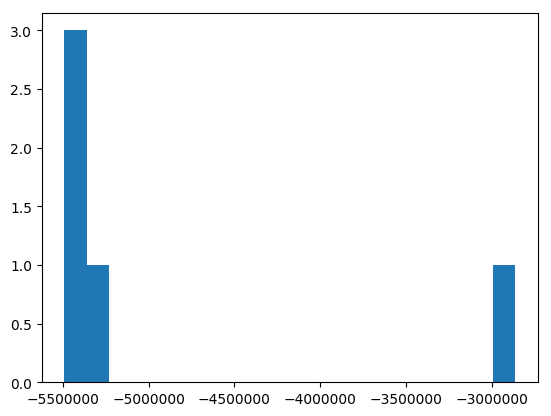

In [14]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

In [15]:
# Visualizing test simulation:

# test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
# HTML(test_anim.to_html5_video())


/home/user/envs/rl/lib/python3.5/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


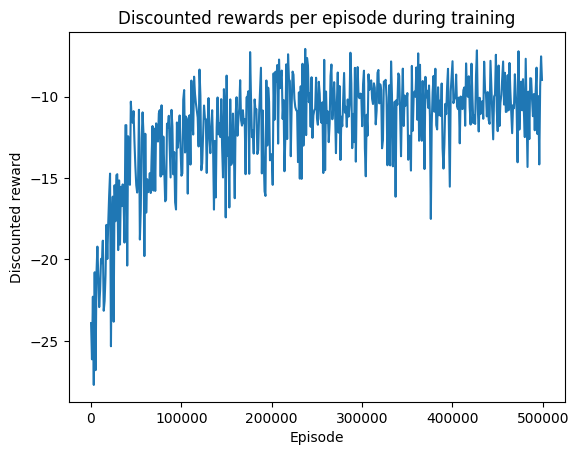

In [16]:
# Visualizing train simulation:

# episode =episodes
#simulation_id = 2
# step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,episodes,10)]

plt.plot(discrewards['episode'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.savefig(simulation_directory + '/discounted-rewards-sim' + '{}'.format(simulation_id) + '.pdf')

plt.show()
plt.close()


### Test visualization

In [17]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks
    
    def my_indicator(x_min, x, x_max):
            if (x> x_min) & (x<=x_max):
                return 1
            else: 
                return 0
    def is_empty(x):
        if x <=0:
            return 1
        else: 
            return 0
        
    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))
        ##################### Count number of times the system is in (0,b), (b,c),(c,e),(e,1) ##########
        b = percentages[0]
        level_counts = np.zeros(5, dtype = np.int64)
        
        x_mins = np.array([0,b,c,e])*tanks[i-1].max_load
        x_maxs = np.array([b,c,e,1])*tanks[i-1].max_load

        for x in states:
            level_counts[0] = level_counts[0] + is_empty(x)
            for j in range(1,5):
                level_counts[j] = level_counts[j] + my_indicator(x_mins[j-1], x, x_maxs[j-1])
            
        level_counts_list.append(level_counts)



    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [20]:

def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1,
                   noise = False):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(noise, seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = False

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
    test_number_of_first_trucks_sent_list = []
    test_number_of_second_trucks_sent_list = []
    test_number_of_trucks_not_deliverying_list = []
    
    test_level_counts_list = []
    
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list = test_number_of_first_trucks_sent_list,           
           number_of_second_trucks_sent_list=test_number_of_second_trucks_sent_list, 
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        test_level_counts_list)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)

    #     if n_episodes == 1:
    first_type = sum(test_number_of_first_trucks_sent_list)/n_episodes
    print("Average 1st type Trucks sent to each shop:", first_type)
    print("Average 1st type Trucks sent:", sum(first_type[0:n] ) )

    second_type = sum(test_number_of_second_trucks_sent_list)/n_episodes
    print("Average 2nd type Trucks sent to each shop:", second_type)
    print("Average 2nd type Trucks sent:",  sum(second_type[0:n] ))

    print("Average number of trucks not deliverying:", sum(test_number_of_trucks_not_deliverying_list)/n_episodes )

    for i in range(n):
            print("Average level counts for shop {}:".format(i), test_level_counts_list[i]/n_episodes )


    print("Average total level counts:", sum(test_level_counts_list)/n_episodes )
    print("Percentage total level counts:", (sum(test_level_counts_list)/n_episodes)/(episode_length * n) * 100 )

    
test_episodes = 10

### Deterministic consumption rates without transport/unload costs, 0.5M episodes 

Test episode: 1
Episode 1 t 0 -1333.8216445 -1333.8216445 0.0 5500
Episode 1 t 1 -498.4153942 -498.4153942 0.0 5500
Episode 1 t 2 -858.0806194 -294.7068994 563.37372 4500
Episode 1 t 3 -550.7873265 -435.2234865 115.56384 0500
Episode 1 t 4 -1007.720639 -444.346919 563.37372 4500
Episode 1 t 5 -967.2909193 -382.2489793 585.04194 2500
Episode 1 t 6 -721.0033138 -157.6295938 563.37372 4500
Episode 1 t 7 -1082.187069 -1082.187069 0.0 5500
Episode 1 t 8 -5813.6394704 -5698.0756304 115.56384 0500
Episode 1 t 9 -1000845.8890898 -1000282.5153698 563.37372 4500
Some tank is in a forbidden level
Episode 1 t 10 -1000594.5145146 -1000031.1407946 563.37372 4500
Some tank is in a forbidden level
Episode 1 t 11 -1001420.6091575 -1000835.5672175 585.04194 2500
Some tank is in a forbidden level
Episode 1 t 12 -1001796.8166806 -1001681.2528406 115.56384 0500
Some tank is in a forbidden level
Episode 1 t 13 -2957.5648918 -1347.9256918 1609.6392 4300
Episode 1 t 14 -1954.1265699 -344.4873699 1609.6392 430

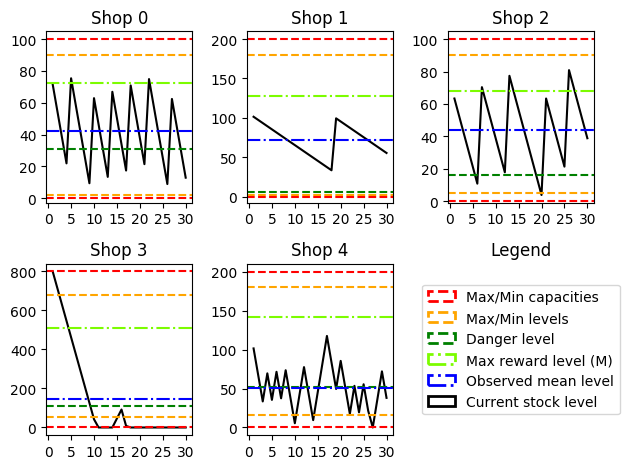

Total discounted rewards Level rewards Transport rewards
-2865931.4688110966 -19132102.43153042 13139.711789999996
Average trucks sent:  27.0
Average 1st type Trucks sent to each shop: [ 7.  1.  4.  0. 13.  5.]
Average 1st type Trucks sent: 25.0
Average 2nd type Trucks sent to each shop: [ 0.  0.  0.  2.  0. 28.]
Average 2nd type Trucks sent: 2.0
Average number of trucks not deliverying: 0.0
Average level counts for shop 0: [ 0.  0. 11. 19.  0.]
Average level counts for shop 1: [ 0.  0.  0. 30.  0.]
Average level counts for shop 2: [ 0.  1.  2. 27.  0.]
Average level counts for shop 3: [17.  3.  1.  7.  2.]
Average level counts for shop 4: [ 1.  2. 14. 13.  0.]
Average total level counts: [18.  6. 28. 96.  2.]
Percentage total level counts: [12.          4.         18.66666667 64.          1.33333333]


In [19]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 1)


Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Test episode: 5
Test episode: 6
Test episode: 7
Test episode: 8
Test episode: 9
Test episode: 10
Test episode: 11
Test episode: 12
Test episode: 13
Test episode: 14
Test episode: 15
Test episode: 16
Test episode: 17
Test episode: 18
Test episode: 19
Test episode: 20
Test episode: 21
Test episode: 22
Test episode: 23
Test episode: 24
Test episode: 25
Test episode: 26
Test episode: 27
Test episode: 28
Test episode: 29
Test episode: 30
Test episode: 31
Test episode: 32
Test episode: 33
Test episode: 34
Test episode: 35
Test episode: 36
Test episode: 37
Test episode: 38
Test episode: 39
Test episode: 40
Test episode: 41
Test episode: 42
Test episode: 43
Test episode: 44
Test episode: 45
Test episode: 46
Test episode: 47
Test episode: 48
Test episode: 49
Test episode: 50
Test episode: 51
Test episode: 52
Test episode: 53
Test episode: 54
Test episode: 55
Test episode: 56
Test episode: 57
Test episode: 58
Test episode: 59
Test e

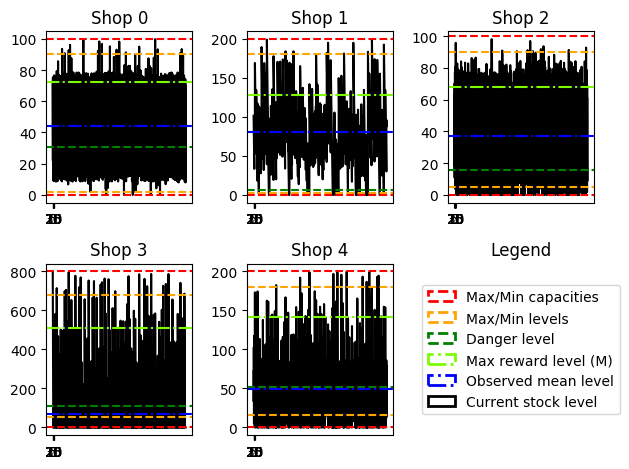

Total discounted rewards Level rewards Transport rewards
-6267245.137321573 -29690599.36234374 11669.621085899997
Average trucks sent:  25.49
Average 1st type Trucks sent to each shop: [ 6.72  0.59  3.93  0.82 12.96  4.98]
Average 1st type Trucks sent: 25.020000000000003
Average 2nd type Trucks sent to each shop: [ 0.    0.    0.    0.47  0.   29.53]
Average 2nd type Trucks sent: 0.47
Average number of trucks not deliverying: 0.01
Average level counts for shop 0: [4.000e-02 1.000e-02 9.400e+00 2.036e+01 1.900e-01]
Average level counts for shop 1: [ 1.71  0.11  0.18 27.7   0.3 ]
Average level counts for shop 2: [ 2.31  0.89  3.   23.69  0.11]
Average level counts for shop 3: [22.74  1.08  0.68  5.17  0.33]
Average level counts for shop 4: [ 1.33  3.11 13.76 11.68  0.12]
Average total level counts: [28.13  5.2  27.02 88.6   1.05]
Percentage total level counts: [18.75333333  3.46666667 18.01333333 59.06666667  0.7       ]


In [23]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 100)
